# MISA Project Atlas experiments notebook

## Students: Leonardo Pestana Legori, Lisle Faray de Paiva

In [2]:
PROJECT_FOLDER = "D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project"
DATA_FOLDER = PROJECT_FOLDER + "\\dataset"

## Register atlases

In [3]:
import SimpleITK as sitk
import os

In [4]:
def register_elastix(
    fixed_image,
    moving_image,
    parameters,
    output_dir,
    fixed_mask=None,
    moving_mask=None,
    verbose=False,
):
    """
    Register two images using elastix.

    Parameters
    ----------
    fixed_image (SimpleITK image): Fixed image.
    moving_image (SimpleITK image): Moving image.
    parameters (SimpleITK parameter map): Elastix parameter map.
    output_dir (str): Output directory.
    fixed_mask (SimpleITK image): Optional fixed mask.
    moving_mask (SimpleITK image): Optional moving mask.
    verbose (bool): Optional verbose output.

    Returns
    -------
    Tuple[SimpleITK image, SimpleITK parameter map] or None if fails.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # set up for registration
    elastix_image_filter = sitk.ElastixImageFilter()
    elastix_image_filter.SetFixedImage(fixed_image)
    elastix_image_filter.SetMovingImage(moving_image)
    if len(parameters) == 1:
        elastix_image_filter.SetParameterMap(parameters[0])
    else:
        elastix_image_filter.SetParameterMap(parameters[0])
        for parameter in parameters[1:]:
            elastix_image_filter.AddParameterMap(parameter)  
    elastix_image_filter.SetOutputDirectory(output_dir)
    elastix_image_filter.LogToConsoleOn()
    elastix_image_filter.LogToFileOn()
    elastix_image_filter.SetNumberOfThreads(8)
    
    # set up for optional components
    if fixed_mask:
        fixed_mask.CopyInformation(fixed_image)
        elastix_image_filter.SetFixedMask(fixed_mask)
    if moving_mask:
        moving_mask.CopyInformation(moving_image)
        elastix_image_filter.SetMovingMask(moving_mask)

    # perform registration
    try:
        elastix_image_filter.Execute()
    except RuntimeError as e:
        print(e)
        return None

    # get result
    result_image = elastix_image_filter.GetResultImage()
    parameter_map = elastix_image_filter.GetTransformParameterMap()

    # Print results
    if verbose:
        print("Result image:")
        print(result_image)
        print("Result image spacing:")
        print(result_image.GetSpacing())
        print("Result image origin:")
        print(result_image.GetOrigin())
        print("Result image direction:")
        print(result_image.GetDirection())

    return result_image, parameter_map

In [5]:
def transform_labels(
    label_image,
    transform_parameter_map,
    output_dir,
    verbose=False,
):
    """
    Transform labels using elastix.

    Parameters
    ----------
    label_image (SimpleITK image): Label image.
    transform_parameter_map (SimpleITK parameter map): Elastix transform parameter map.
    reference_image (SimpleITK image): Reference image.
    output_dir (str): Output directory.
    verbose (bool): Optional verbose output.

    Returns
    -------
    SimpleITK image or None if fails.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # set up for transformation
    transformix_image_filter = sitk.TransformixImageFilter()
    transformix_image_filter.SetTransformParameterMap(transform_parameter_map)

    # change for label image
    transformix_image_filter.SetTransformParameter("FinalBSplineInterpolationOrder", "0")
    transformix_image_filter.SetTransformParameter("ResultImagePixelType", "short")
    # transformix_image_filter.SetTransformParameter("ResampleInterpolator", "FinalNearestNeighborInterpolator")
    
    transformix_image_filter.SetMovingImage(label_image)
    transformix_image_filter.SetOutputDirectory(output_dir)
    transformix_image_filter.LogToConsoleOn()
    transformix_image_filter.LogToFileOn()
    
    # perform transformation
    try:
        transformix_image_filter.Execute()
    except RuntimeError as e:
        print(e)
        return None

    # get result
    result_image = transformix_image_filter.GetResultImage()

    # Print results
    if verbose:
        print("Result image:")
        print(result_image)
        print("Result image spacing:")
        print(result_image.GetSpacing())
        print("Result image origin:")
        print(result_image.GetOrigin())
        print("Result image direction:")
        print(result_image.GetDirection())

    return result_image

## Test registration

In [6]:

img_train =[sitk.ReadImage(DATA_FOLDER + "\\Training_Set\\IBSR_01\\IBSR_01.nii.gz")]
label_train = [sitk.ReadImage(DATA_FOLDER + "\\Training_Set\\IBSR_01\\IBSR_01_seg.nii.gz")]

img_val = [sitk.ReadImage(DATA_FOLDER + "\\Validation_Set\\IBSR_17\\IBSR_17.nii.gz")]
label_val = [sitk.ReadImage(DATA_FOLDER + "\\Validation_Set\\IBSR_17\\IBSR_17_seg.nii.gz")]


In [7]:
def get_img_info(img):
    print(f"Image info:",
            f"\n\tSize: {img.GetSize()}",
            f"\n\tSpacing: {img.GetSpacing()}",
            f"\n\tOrigin: {img.GetOrigin()}",
            f"\n\tDirection: {img.GetDirection()}",
            f"\n\tPixel type: {img.GetPixelIDTypeAsString()}",)
    
print("Training set:")
get_img_info(img_train[0])
get_img_info(label_train[0])
print("Validation set:")
get_img_info(img_val[0])
get_img_info(label_val[0])

Training set:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.9375, 1.5, 0.9375) 
	Origin: (239.0625, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.9375, 1.5, 0.9375) 
	Origin: (239.0625, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer
Validation set:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370535969734192, 1.5, 0.8370535969734192) 
	Origin: (213.44866943359375, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370535969734192, 1.5, 0.8370535969734192) 
	Origin: (213.44866943359375, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer


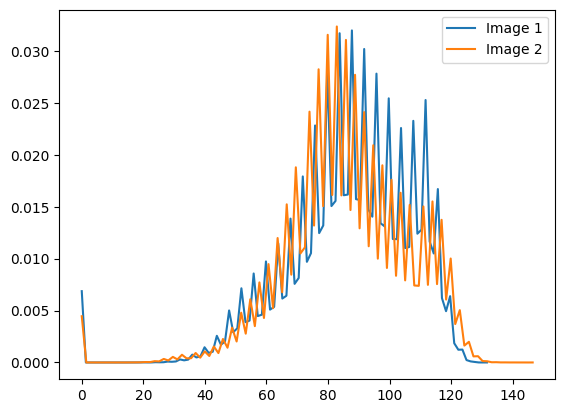

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(img_list, mask_list=None):
    for i, img in enumerate(img_list):
        non_zero_values = sitk.GetArrayViewFromImage(img).flatten()
        if mask_list is not None:
            mask = sitk.GetArrayViewFromImage(mask_list[i]).flatten()
            non_zero_values = non_zero_values[mask != 0]
        else:
            non_zero_values = non_zero_values[non_zero_values != 0]
        hist, bins = np.histogram(non_zero_values, bins=100, density=True)
        plt.plot(bins[:-1], hist)
    plt.legend([f"Image {i+1}" for i in range(len(img_list))])
    plt.show()

plot_histogram([img_train[0], img_val[0]], mask_list=[label_train[0], label_val[0]])


In [9]:
# preprocess images by resampling them to target spacing
# addicionally match the intensity distributions of the images
def resample_image(orig, target, is_label, verbose=False):
    """
    Preprocess image by resampling it to reference image spacing and matching intensity distributions.

    Parameters
    ----------
    orig (SimpleITK image): Image to preprocess.
    target (SimpleITK image): Reference image.
    is_label (bool): Whether the image is a label image.
    verbose (bool): Optional verbose output.

    Returns
    -------
    SimpleITK image.
    """

    # resample image to reference image spacing
    
    resample = sitk.ResampleImageFilter()
    
    resample.SetOutputSpacing(target.GetSpacing())
    resample.SetSize(target.GetSize())
    resample.SetOutputDirection(target.GetDirection())
    resample.SetOutputOrigin(target.GetOrigin())
    resample.SetOutputPixelType(target.GetPixelID())
    # resample.SetTransform(sitk.Transform())
    # resample.SetInterpolator(sitk.sitkLinear)
    # resample.SetInterpolator(sitk.sitkBSpline)
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
    
    orig_resampled = resample.Execute(orig)

    # Print results
    if verbose:
        print("Original image:")
        get_img_info(orig)
        print("Resampled image:")
        get_img_info(orig_resampled)
        print("Reference image:")
        get_img_info(target)
        
    return orig_resampled

In [10]:

def match_histograms(image, reference_image, verbose=False):
    """
    Match intensity distributions of the image and reference image.

    Parameters
    ----------
    image (SimpleITK image): Image to preprocess.
    reference_image (SimpleITK image): Reference image.
    verbose (bool): Optional verbose output.

    Returns
    -------
    SimpleITK image.
    """

    # match intensity distributions of the images
    match = sitk.HistogramMatchingImageFilter()
    if reference_image.GetPixelID() in (sitk.sitkUInt8, sitk.sitkInt8):
        match.SetNumberOfHistogramLevels(128)
    else:
        match.SetNumberOfHistogramLevels(1024)
    match.SetNumberOfMatchPoints(7)
    match.ThresholdAtMeanIntensityOn()
    
    image_matched = match.Execute(image, reference_image)
    

    # Print results
    if verbose:
        print("Original image:")
        get_img_info(image)
        print("Preprocessed image:")
        get_img_info(image_matched)
        
    return image_matched

In [11]:
# print min and max values of images
print(f"img_train min: {sitk.GetArrayViewFromImage(img_train[0]).min()}, max: {sitk.GetArrayViewFromImage(img_train[0]).max()}")
print(f"label_train min: {sitk.GetArrayViewFromImage(label_train[0]).min()}, max: {sitk.GetArrayViewFromImage(label_train[0]).max()}")
print(f"img_val min: {sitk.GetArrayViewFromImage(img_val[0]).min()}, max: {sitk.GetArrayViewFromImage(img_val[0]).max()}")
print(f"label_val min: {sitk.GetArrayViewFromImage(label_val[0]).min()}, max: {sitk.GetArrayViewFromImage(label_val[0]).max()}")

img_train min: 0, max: 173
label_train min: 0, max: 3
img_val min: 0, max: 193
label_val min: 0, max: 3


In [12]:
processed_img_train = [resample_image(img_train[0], img_val[0], is_label=False, verbose=True)]
processed_label_train = [resample_image(label_train[0], img_val[0], is_label=True, verbose=True)]

processed_img_train = [match_histograms(processed_img_train[0], img_val[0], verbose=True)]


# mask the images
# processed_img_train = [sitk.Mask(processed_img_train[0], processed_label_train[0])]


Original image:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.9375, 1.5, 0.9375) 
	Origin: (239.0625, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer
Resampled image:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370535969734192, 1.5, 0.8370535969734192) 
	Origin: (213.44866943359375, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer
Reference image:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370535969734192, 1.5, 0.8370535969734192) 
	Origin: (213.44866943359375, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer
Original image:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.9375, 1.5, 0.9375) 
	Origin: (239.0625, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer
Resampled image:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370535

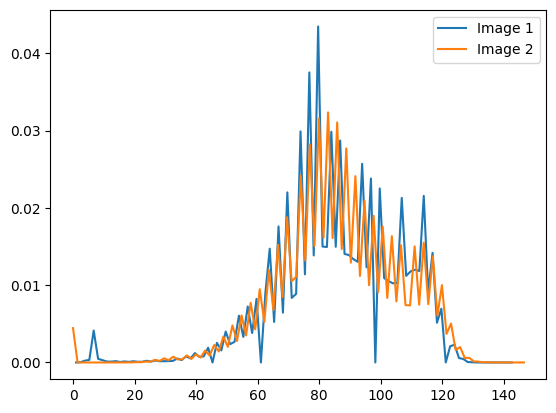

In [13]:
# plot histograms of images
plot_histogram([processed_img_train[0], img_val[0]], mask_list=[processed_label_train[0], label_val[0]])

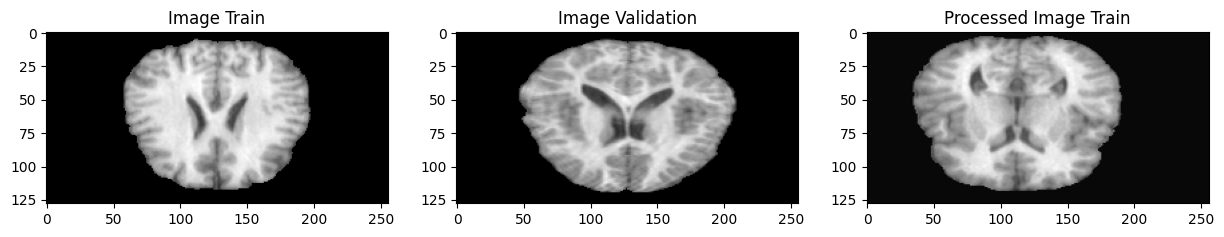

In [14]:
# plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayViewFromImage(img_train[0])[150,:,:], cmap="gray")
plt.title("Image Train")

plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayViewFromImage(img_val[0])[150,:,:], cmap="gray")
plt.title("Image Validation")

plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayViewFromImage(processed_img_train[0])[150,:,:], cmap="gray")
plt.title("Processed Image Train")

plt.show()

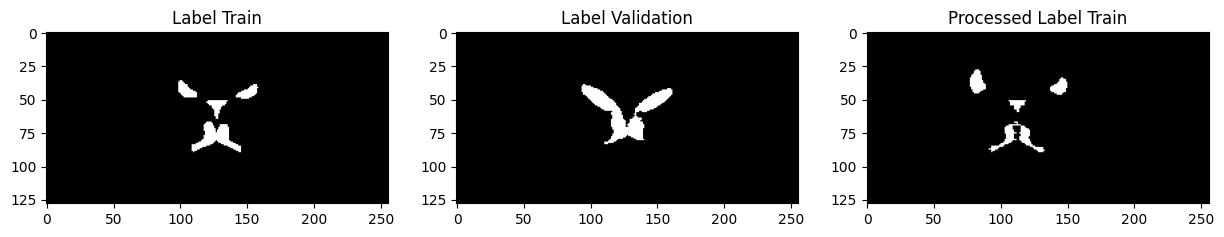

In [15]:
processed_label_train = [resample_image(label_train[0], img_val[0], is_label=True, verbose=False)]

# plot lablels
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayViewFromImage(label_train[0])[140,:,:] == 1, cmap="gray")
plt.title("Label Train")

plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayViewFromImage(label_val[0])[150,:,:] == 1, cmap="gray")
plt.title("Label Validation")

plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayViewFromImage(processed_label_train[0])[150,:,:] == 1, cmap="gray")
plt.title("Processed Label Train")

plt.show()

In [16]:
# get parameters
param1 = sitk.ReadParameterFile("../parameter_files/Par0010/Par0010affine.txt")
param2 = sitk.ReadParameterFile("../parameter_files/Par0010/Par0010bspline.txt")
all_params = [param1, param2]

In [17]:
reg_img, parameter_map = register_elastix(
    fixed_image=img_val[0],
    moving_image=processed_img_train[0],
    parameters=all_params,
    output_dir=PROJECT_FOLDER + "\\atlas\\output\\elastix\\IBSR_01",
    verbose=True,
)

Result image:
Image (0000023D256977E0)
  RTTI typeinfo:   class itk::Image<float,3>
  Reference Count: 2
  Modified Time: 387447
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 128, 256]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 128, 256]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 128, 256]
  Spacing: [0.837054, 1.5, 0.837054]
  Origin: [213.449, -0, 0]
  Direction: 
-1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
-0.837054 0 0
0 -1.5 0
0 0 0.837054

  PointToIndexMatrix: 
-1.19467 0 0
0 -0.666667 0
0 0 1.19467

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0000023D24813EF0)
      RTTI typeinfo:   class itk::ImportImageContainer

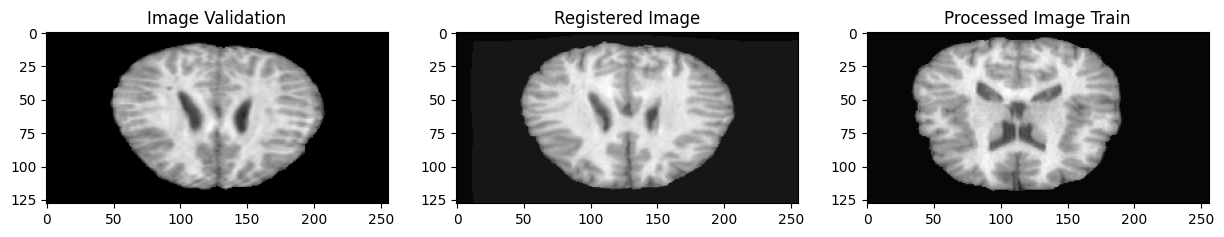

Registered image:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370535969734192, 1.5, 0.8370535969734192) 
	Origin: (213.44866943359375, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 32-bit float
Validated image:
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370535969734192, 1.5, 0.8370535969734192) 
	Origin: (213.44866943359375, -0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 16-bit signed integer


In [19]:
# plot images
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayViewFromImage(img_val[0])[160,:,:], cmap="gray")
plt.title("Image Validation")
plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayViewFromImage(reg_img)[160,:,:], cmap="gray")
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayViewFromImage(processed_img_train[0])[160,:,:], cmap="gray")
plt.title("Processed Image Train")
plt.show()

# print info about registered image
print("Registered image:")
get_img_info(reg_img)
print("Validated image:")
get_img_info(img_val[0])


In [20]:
# write registered image to file
sitk.WriteImage(reg_img, PROJECT_FOLDER + "\\atlas\\output\\elastix\\IBSR_01\\IBSR_01_reg.nii.gz")

In [21]:
# transform labels
reg_label = transform_labels(
    label_image=processed_label_train[0],
    transform_parameter_map=parameter_map,
    output_dir=PROJECT_FOLDER + "\\atlas\\output\\elastix\\IBSR_01\\labels",
    verbose=True,
)

Result image:
Image (0000023D25697D80)
  RTTI typeinfo:   class itk::Image<float,3>
  Reference Count: 2
  Modified Time: 388133
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 128, 256]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 128, 256]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 128, 256]
  Spacing: [0.837054, 1.5, 0.837054]
  Origin: [213.449, -0, 0]
  Direction: 
-1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
-0.837054 0 0
0 -1.5 0
0 0 0.837054

  PointToIndexMatrix: 
-1.19467 0 0
0 -0.666667 0
0 0 1.19467

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0000023D24812AF0)
      RTTI typeinfo:   class itk::ImportImageContainer

Text(0.5, 1.0, 'Label Validation')

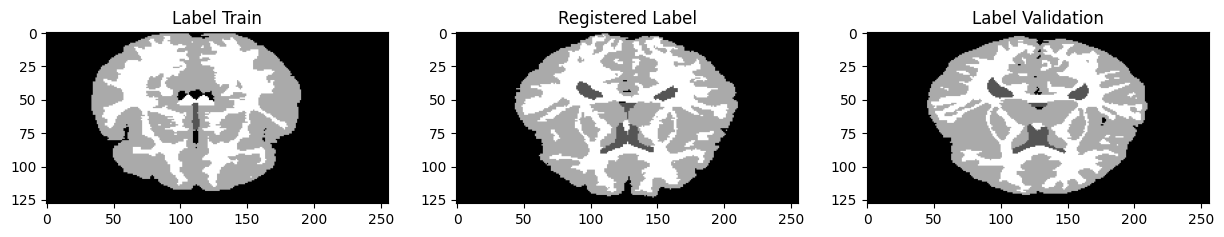

In [22]:
# Define the slice index
slice_index = 140

# Plot original and transformed labels
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayViewFromImage(processed_label_train[0])[slice_index,:,:], cmap="gray")
plt.title("Label Train")
plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayViewFromImage(reg_label)[slice_index,:,:], cmap="gray")
plt.title("Registered Label")
plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayViewFromImage(label_val[0])[slice_index,:,:], cmap="gray")
plt.title("Label Validation")

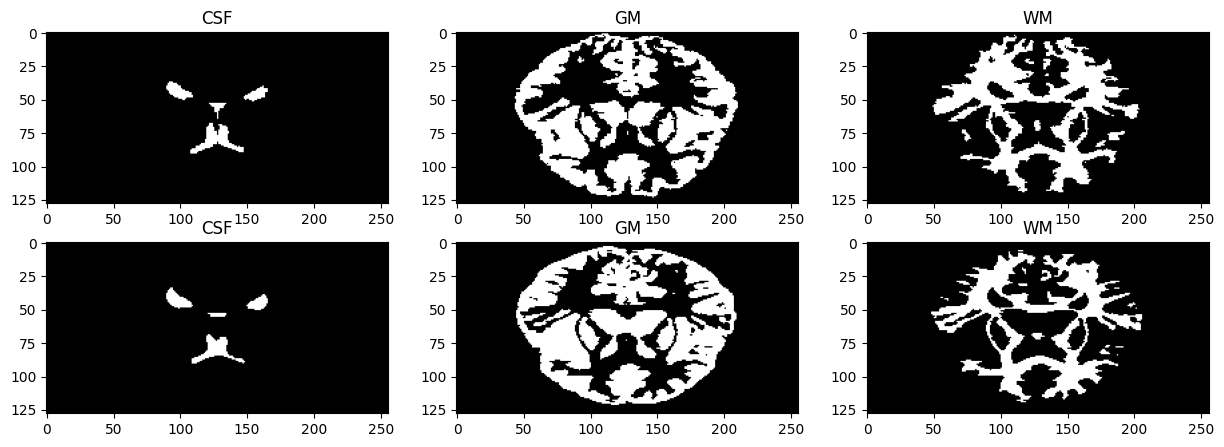

In [23]:
# plot csf, gm and wm labels
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
plt.imshow(sitk.GetArrayViewFromImage(reg_label)[slice_index,:,:] == 1, cmap="gray")
plt.title("CSF")
plt.subplot(2,3,2)
plt.imshow(sitk.GetArrayViewFromImage(reg_label)[slice_index,:,:] == 2, cmap="gray")
plt.title("GM")
plt.subplot(2,3,3)
plt.imshow(sitk.GetArrayViewFromImage(reg_label)[slice_index,:,:] == 3, cmap="gray")
plt.title("WM")
plt.subplot(2,3,4)
plt.imshow(sitk.GetArrayViewFromImage(label_val[0])[slice_index,:,:] == 1, cmap="gray")
plt.title("CSF")
plt.subplot(2,3,5)
plt.imshow(sitk.GetArrayViewFromImage(label_val[0])[slice_index,:,:] == 2, cmap="gray")
plt.title("GM")
plt.subplot(2,3,6)
plt.imshow(sitk.GetArrayViewFromImage(label_val[0])[slice_index,:,:] == 3, cmap="gray")
plt.title("WM")

plt.show()

In [24]:
# write registered label to file
sitk.WriteImage(reg_label, PROJECT_FOLDER + "\\atlas\\output\\elastix\\IBSR_01\\labels\\IBSR_01_reg_label.nii.gz")

## Register atlases

In [92]:
import glob

In [93]:
# normalize the base directory
base_dir = os.path.normpath(DATA_FOLDER)

# get all the filenames recursively
train_filenames = glob.glob(
    os.path.join(base_dir, "Training_Set", "**", "*.nii.gz"), recursive=True
)
val_filenames = glob.glob(
    os.path.join(base_dir, "Validation_Set", "**", "*.nii.gz"), recursive=True
)
test_filenames = glob.glob(
    os.path.join(base_dir, "Test_Set", "**", "*.nii.gz"), recursive=True
)

# # keep only the two last folder names and the filename
# train_filenames = [
#     os.path.join(
#         os.path.basename(os.path.dirname(os.path.dirname(filename))),
#         os.path.basename(os.path.dirname(filename)),
#         os.path.basename(filename),
#     )
#     for filename in train_filenames
# ]
# val_filenames = [
#     os.path.join(
#         os.path.basename(os.path.dirname(os.path.dirname(filename))),
#         os.path.basename(os.path.dirname(filename)),
#         os.path.basename(filename),
#     )
#     for filename in val_filenames
# ]
# test_filenames = [
#     os.path.join(
#         os.path.basename(os.path.dirname(os.path.dirname(filename))),
#         os.path.basename(os.path.dirname(filename)),
#         os.path.basename(filename),
#     )
#     for filename in test_filenames
# ]

# for the testing set, create a list of dictionaries with only the image filenames
test_dict = [{"image": filename, "filename": os.path.basename(filename.split(".")[0])} for filename in test_filenames]

# separate segmentation files
train_seg_filenames = [
    filename for filename in train_filenames if "seg" in filename
]
train_image_filenames = [
    filename for filename in train_filenames if "seg" not in filename
]
val_seg_filenames = [filename for filename in val_filenames if "seg" in filename]
val_image_filenames = [
    filename for filename in val_filenames if "seg" not in filename
]

# add the both image and segmentation filenames to a list of dictionaries
train_dict = [
    {"image": image_filename, "label": seg_filename, "filename": os.path.basename(image_filename.split(".")[0])}
    for image_filename, seg_filename in zip(
        train_image_filenames, train_seg_filenames
    )
]
val_dict = [
    {"image": image_filename, "label": seg_filename, "filename": os.path.basename(image_filename.split(".")[0])}
    for image_filename, seg_filename in zip(val_image_filenames, val_seg_filenames)
]

In [103]:
# create a single dictionary where the keys are the filenames (for train, val and test) and the values are the paths to the files
all_filenames = {**{d["filename"]: d["image"] for d in train_dict}, **{d["filename"]: d["image"] for d in val_dict}, **{d["filename"]: d["image"] for d in test_dict}}

all_filename_seg = {**{d["filename"]: d["label"] for d in train_dict}, **{d["filename"]: d["label"] for d in val_dict}}

In [112]:
def reg_pipeline(
    image_name,
    target_name,
    image_path,
    label_path,
    target_path,
    output_dir,
    verbose=False,
):
    """
    Register image and label to atlas image and label.

    Parameters
    ----------
    image_name (str): Name of the image.
    target_name (str): Name of the target image.
    image_path (str): Path to the image file.
    label_path (str): Path to the label file.
    target_path (str): Path to the target file.
    output_dir (str): Output directory.
    verbose (bool): Optional verbose output.

    Returns
    -------
    Tuple[SimpleITK image, SimpleITK image] or None if fails.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # load image
    image = sitk.ReadImage(image_path)

    # load label
    label = sitk.ReadImage(label_path)

    # load target
    target = sitk.ReadImage(target_path)

    # preprocess images
    image = resample_image(image, target, is_label=False, verbose=verbose)
    image = match_histograms(image, target, verbose=verbose)
    label = resample_image(label, target, is_label=True, verbose=verbose)
    # image = sitk.Mask(image, label)

    # register images
    reg_image, parameter_map = register_elastix(
        fixed_image=target,
        moving_image=image,
        parameters=all_params,
        output_dir=os.path.join(output_dir, "temp", f"{image_name}_{target_name}"),
        verbose=verbose,
    )

    # transform labels
    reg_label = transform_labels(
        label_image=label,
        transform_parameter_map=parameter_map,
        output_dir=os.path.join(output_dir, "temp", f"{image_name}_{target_name}"),
        verbose=verbose,
    )
    
    # write registered label to file
    output_file_label = os.path.join(output_dir, "results", f"{image_name}_{target_name}_reg_label.nii.gz")
    if not os.path.exists(os.path.dirname(output_file_label)):
        os.makedirs(os.path.dirname(output_file_label))
    sitk.WriteImage(reg_label, output_file_label)
    
    # write registered image to file
    output_file_image = os.path.join(output_dir, "results", f"{image_name}_{target_name}_reg.nii.gz")
    if not os.path.exists(os.path.dirname(output_file_image)):
        os.makedirs(os.path.dirname(output_file_image))
    sitk.WriteImage(reg_image, output_file_image)

In [114]:
# register training images to validation images
for i in range(len(train_dict)):
    for j in range(len(val_dict)):
        print(f"Registering {train_dict[i]['filename']} to {val_dict[j]['filename']} ({i+1}/{len(train_dict)}, {j+1}/{len(val_dict)})")
        reg_pipeline(
            image_name=train_dict[i]['filename'],
            target_name=val_dict[j]['filename'],
            image_path=train_dict[i]['image'],
            label_path=train_dict[i]['label'],
            target_path=val_dict[j]['image'],
            output_dir=os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "val"),
            verbose=False,
        )

Registering IBSR_01 to IBSR_11 (1/10, 1/5)
Registering IBSR_01 to IBSR_12 (1/10, 2/5)
Registering IBSR_01 to IBSR_13 (1/10, 3/5)
Registering IBSR_01 to IBSR_14 (1/10, 4/5)
Registering IBSR_01 to IBSR_17 (1/10, 5/5)
Registering IBSR_03 to IBSR_11 (2/10, 1/5)
Registering IBSR_03 to IBSR_12 (2/10, 2/5)
Registering IBSR_03 to IBSR_13 (2/10, 3/5)
Registering IBSR_03 to IBSR_14 (2/10, 4/5)
Registering IBSR_03 to IBSR_17 (2/10, 5/5)
Registering IBSR_04 to IBSR_11 (3/10, 1/5)
Registering IBSR_04 to IBSR_12 (3/10, 2/5)
Registering IBSR_04 to IBSR_13 (3/10, 3/5)
Registering IBSR_04 to IBSR_14 (3/10, 4/5)
Registering IBSR_04 to IBSR_17 (3/10, 5/5)
Registering IBSR_05 to IBSR_11 (4/10, 1/5)
Registering IBSR_05 to IBSR_12 (4/10, 2/5)
Registering IBSR_05 to IBSR_13 (4/10, 3/5)
Registering IBSR_05 to IBSR_14 (4/10, 4/5)
Registering IBSR_05 to IBSR_17 (4/10, 5/5)
Registering IBSR_06 to IBSR_11 (5/10, 1/5)
Registering IBSR_06 to IBSR_12 (5/10, 2/5)
Registering IBSR_06 to IBSR_13 (5/10, 3/5)
Registering

In [115]:
# register training images to test images
for i in range(len(train_dict)):
    for j in range(len(test_dict)):
        print(f"Registering {train_dict[i]['filename']} to {test_dict[j]['filename']} ({i+1}/{len(train_dict)}, {j+1}/{len(test_dict)})")
        reg_pipeline(
            image_name=train_dict[i]['filename'],
            target_name=test_dict[j]['filename'],
            image_path=train_dict[i]['image'],
            label_path=train_dict[i]['label'],
            target_path=test_dict[j]['image'],
            output_dir=os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "test"),
            verbose=False,
        )

Registering IBSR_01 to IBSR_02 (1/10, 1/3)


Registering IBSR_01 to IBSR_10 (1/10, 2/3)
Registering IBSR_01 to IBSR_15 (1/10, 3/3)
Registering IBSR_03 to IBSR_02 (2/10, 1/3)
Registering IBSR_03 to IBSR_10 (2/10, 2/3)
Registering IBSR_03 to IBSR_15 (2/10, 3/3)
Registering IBSR_04 to IBSR_02 (3/10, 1/3)
Registering IBSR_04 to IBSR_10 (3/10, 2/3)
Registering IBSR_04 to IBSR_15 (3/10, 3/3)
Registering IBSR_05 to IBSR_02 (4/10, 1/3)
Registering IBSR_05 to IBSR_10 (4/10, 2/3)
Registering IBSR_05 to IBSR_15 (4/10, 3/3)
Registering IBSR_06 to IBSR_02 (5/10, 1/3)
Registering IBSR_06 to IBSR_10 (5/10, 2/3)
Registering IBSR_06 to IBSR_15 (5/10, 3/3)
Registering IBSR_07 to IBSR_02 (6/10, 1/3)
Registering IBSR_07 to IBSR_10 (6/10, 2/3)
Registering IBSR_07 to IBSR_15 (6/10, 3/3)
Registering IBSR_08 to IBSR_02 (7/10, 1/3)
Registering IBSR_08 to IBSR_10 (7/10, 2/3)
Registering IBSR_08 to IBSR_15 (7/10, 3/3)
Registering IBSR_09 to IBSR_02 (8/10, 1/3)
Registering IBSR_09 to IBSR_10 (8/10, 2/3)
Registering IBSR_09 to IBSR_15 (8/10, 3/3)
Registering

## Generate metrics for weighting the atlases

In [116]:
import pandas as pd
import itertools

# Get the filenames of moving images (train)
moving_images = [train_dict[i]['filename'] for i in range(len(train_dict))]

# Get the filenames of fixed images (val and test)
fixed_images_val = [val_dict[j]['filename'] for j in range(len(val_dict))]
fixed_images_test = [test_dict[j]['filename'] for j in range(len(test_dict))]

# Generate all combinations of moving and fixed images
combinations_val = list(itertools.product(moving_images, fixed_images_val))
combinations_test = list(itertools.product(moving_images, fixed_images_test))

# Create dataframes with the combinations
df_val = pd.DataFrame(combinations_val, columns=['Moving Image', 'Fixed Image'])
df_test = pd.DataFrame(combinations_test, columns=['Moving Image', 'Fixed Image'])

# Add the "Fixed Type" column
df_val['Fixed Type'] = 'val'
df_test['Fixed Type'] = 'test'

# Concatenate the dataframes
df = pd.concat([df_val, df_test], ignore_index=True)

# Print the dataframe
print(df)


   Moving Image Fixed Image Fixed Type
0       IBSR_01     IBSR_11        val
1       IBSR_01     IBSR_12        val
2       IBSR_01     IBSR_13        val
3       IBSR_01     IBSR_14        val
4       IBSR_01     IBSR_17        val
..          ...         ...        ...
75      IBSR_16     IBSR_10       test
76      IBSR_16     IBSR_15       test
77      IBSR_18     IBSR_02       test
78      IBSR_18     IBSR_10       test
79      IBSR_18     IBSR_15       test

[80 rows x 3 columns]


In [117]:
# using glob, get all the filenames recursively from the results folder
reg_train_filenames = glob.glob(
    os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "**", "results", "**", "*.nii.gz"), recursive=True
)

len(reg_train_filenames)

160

In [119]:
# add to the dataframe the filenames of the registered images (matching the moving and fixed images)
df['Registered Image'] = df.apply(lambda row: [filename for filename in reg_train_filenames if row['Moving Image'] in filename and row['Fixed Image'] in filename][0], axis=1)

# add to the dataframe the filenames of the registered labels (matching the moving and fixed images)
df['Registered Label'] = df.apply(lambda row: [filename for filename in reg_train_filenames if row['Moving Image'] in filename and row['Fixed Image'] in filename and "label" in filename][0], axis=1)

In [120]:
# add to the dataframe the filenames of the validation segmentation labels (val_seg_filenames) - filter by 'val' in the 'Fixed Type' column
df['Validation Label'] = df.apply(lambda row: [filename for filename in val_seg_filenames if row['Fixed Image'] in filename][0] if row['Fixed Type'] == 'val' else None, axis=1)

In [122]:
df.head()

,Moving Image,Fixed Image,Fixed Type,Registered Image,Registered Label,Validation Label
0,IBSR_01,IBSR_11,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
1,IBSR_01,IBSR_12,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
2,IBSR_01,IBSR_13,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
3,IBSR_01,IBSR_14,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
4,IBSR_01,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...


In [123]:
df.loc[(df['Moving Image'] == "IBSR_16") & (df['Fixed Image'] == "IBSR_13"), 'Registered Image'].iloc[0]

'D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project\\atlas\\output\\elastix\\val\\results\\IBSR_16_IBSR_13_reg.nii.gz'

In [124]:
df.loc[(df['Moving Image'] == "IBSR_16") & (df['Fixed Image'] == "IBSR_13"), 'Registered Label'].iloc[0]

'D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project\\atlas\\output\\elastix\\val\\results\\IBSR_16_IBSR_13_reg_label.nii.gz'

In [125]:
# loop over validation images and print their pixel type
for i in range(len(val_dict)):
    print(f"Image {val_dict[i]['filename']}: {sitk.GetArrayViewFromImage(sitk.ReadImage(val_dict[i]['image'])).dtype}")
    
# loop over test images and print their pixel type
for i in range(len(test_dict)):
    print(f"Image {test_dict[i]['filename']}: {sitk.GetArrayViewFromImage(sitk.ReadImage(test_dict[i]['image'])).dtype}")
    
# loop over registered images and print their pixel type
for i in range(len(reg_train_filenames)):
    print(f"Image {reg_train_filenames[i].split(os.sep)[-1].split('.')[0]}\t: {sitk.GetArrayViewFromImage(sitk.ReadImage(reg_train_filenames[i])).dtype}")

Image IBSR_11: int16
Image IBSR_12: int16


Image IBSR_13: int16
Image IBSR_14: int16
Image IBSR_17: int16
Image IBSR_02: int16
Image IBSR_10: int16
Image IBSR_15: int16
Image IBSR_01_IBSR_02_reg	: float32
Image IBSR_01_IBSR_02_reg_label	: float32
Image IBSR_01_IBSR_10_reg	: float32
Image IBSR_01_IBSR_10_reg_label	: float32
Image IBSR_01_IBSR_15_reg	: float32
Image IBSR_01_IBSR_15_reg_label	: float32
Image IBSR_03_IBSR_02_reg	: float32
Image IBSR_03_IBSR_02_reg_label	: float32
Image IBSR_03_IBSR_10_reg	: float32
Image IBSR_03_IBSR_10_reg_label	: float32
Image IBSR_03_IBSR_15_reg	: float32
Image IBSR_03_IBSR_15_reg_label	: float32
Image IBSR_04_IBSR_02_reg	: float32
Image IBSR_04_IBSR_02_reg_label	: float32
Image IBSR_04_IBSR_10_reg	: float32
Image IBSR_04_IBSR_10_reg_label	: float32
Image IBSR_04_IBSR_15_reg	: float32
Image IBSR_04_IBSR_15_reg_label	: float32
Image IBSR_05_IBSR_02_reg	: float32
Image IBSR_05_IBSR_02_reg_label	: float32
Image IBSR_05_IBSR_10_reg	: float32
Image IBSR_05_IBSR_10_reg_label	: float32
Image IBSR_05_IB

In [126]:
# Function to load image based on filename
def load_image(filename, filename2=None):
    if filename2 is not None:
        image_path = df.loc[(df['Moving Image'] == filename) & (df['Fixed Image'] == filename2), 'Registered Image'].iloc[0]
        print(image_path)
    else:
        # get the path from the dictionary
        image_path = all_filenames[filename]
        print(image_path)
        
    # read image as int16 (necessary for some metrics)
    image = sitk.ReadImage(image_path, sitk.sitkInt16)
    # convert to numpy array
    array = sitk.GetArrayFromImage(image)
    return array

# Calculate Mutual Information (MI) scores
from skimage.metrics import normalized_mutual_information
df['MI'] = df.apply(lambda row: normalized_mutual_information(load_image(row['Moving Image'], row['Fixed Image']), load_image(row['Fixed Image'])), axis=1)

# Calculate Mean Squared Error (MSE) scores
from skimage.metrics import mean_squared_error
df['MSE'] = df.apply(lambda row: mean_squared_error(load_image(row['Moving Image'], row['Fixed Image']), load_image(row['Fixed Image'])), axis=1)

# Calculate Peak Signal to Noise Ratio (PSNR) scores
from skimage.metrics import peak_signal_noise_ratio
df['PSNR'] = df.apply(lambda row: peak_signal_noise_ratio(load_image(row['Moving Image'], row['Fixed Image']), load_image(row['Fixed Image'])), axis=1)

# Calculate Structural Similarity Index (SSIM) scores
from skimage.metrics import structural_similarity
df['SSIM'] = df.apply(lambda row: structural_similarity(load_image(row['Moving Image'], row['Fixed Image']), load_image(row['Fixed Image'])), axis=1)

D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_11_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_11\IBSR_11.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_12_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_12\IBSR_12.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_13_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_13\IBSR_13.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_14_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_14\IBSR_14.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_17_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_17\IBSR_17.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\resul

C:\Users\legor\AppData\Local\Temp\ipykernel_27756\3803776592.py:31: UserWarning: Setting data_range based on im1.dtype. data_range = 65535. Please specify data_range explicitly to avoid mistakes.
  df['SSIM'] = df.apply(lambda row: structural_similarity(load_image(row['Moving Image'], row['Fixed Image']), load_image(row['Fixed Image'])), axis=1)


D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_12_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_12\IBSR_12.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_13_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_13\IBSR_13.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_14_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_14\IBSR_14.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_17_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_17\IBSR_17.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_03_IBSR_11_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_11\IBSR_11.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\resul

In [127]:
df.head()

,Moving Image,Fixed Image,Fixed Type,Registered Image,Registered Label,Validation Label,MI,MSE,PSNR,SSIM
0,IBSR_01,IBSR_11,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.250081,2295.291973,62.721087,0.997290
1,IBSR_01,IBSR_12,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.237932,20.509867,83.209838,0.999977
2,IBSR_01,IBSR_13,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.300537,26.064488,82.168974,0.999979
3,IBSR_01,IBSR_14,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.304216,26.301703,82.129627,0.999981
4,IBSR_01,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.247977,92.626748,76.662102,0.999851


In [128]:
# save dataframe to pickle file
df.to_pickle(PROJECT_FOLDER + "\\atlas\\output\\elastix\\metrics_results.pkl")

## Test segmentation

In [129]:
df_try = df.copy()

# select only the rows we want
df_try = df_try.loc[df_try['Fixed Image'] == "IBSR_17"]
df_try

,Moving Image,Fixed Image,Fixed Type,Registered Image,Registered Label,Validation Label,MI,MSE,PSNR,SSIM
4,IBSR_01,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.247977,92.626748,76.662102,0.999851
9,IBSR_03,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.244712,109.779233,75.924264,0.999821
14,IBSR_04,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.249667,115.162725,75.716347,0.999817
19,IBSR_05,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.257618,123.964956,75.396477,0.999781
24,IBSR_06,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.228561,117.747615,75.619945,0.999811
29,IBSR_07,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.212796,139.265081,74.891044,0.999778
34,IBSR_08,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.210073,144.528462,74.729932,0.999775
39,IBSR_09,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.207235,142.897588,74.779217,0.999765
44,IBSR_16,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.296036,49.357292,79.395953,0.999955
49,IBSR_18,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.288142,52.326519,79.142248,0.999952


In [130]:
df_try['Registered Label'].iloc[0]

'D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project\\atlas\\output\\elastix\\val\\results\\IBSR_01_IBSR_17_reg_label.nii.gz'

In [131]:
# load all the segmentation files
seg_list = [sitk.ReadImage(filename) for filename in df_try['Registered Label']]

IBSR_01


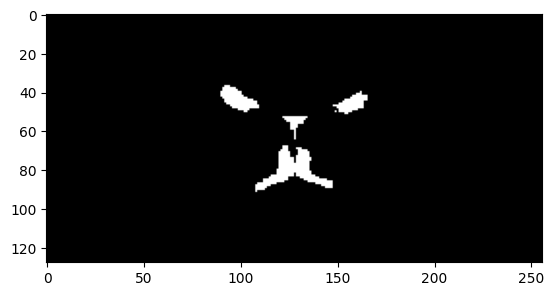

IBSR_03


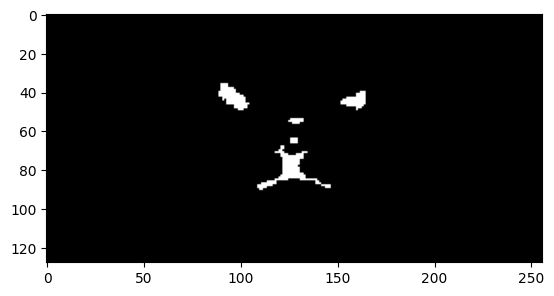

IBSR_04


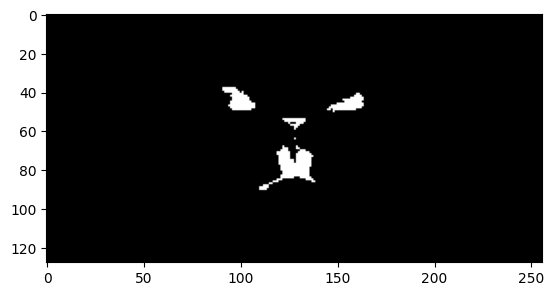

IBSR_05


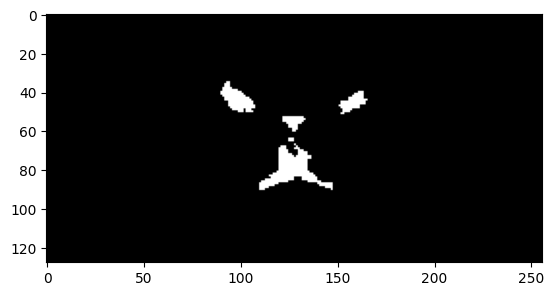

IBSR_06


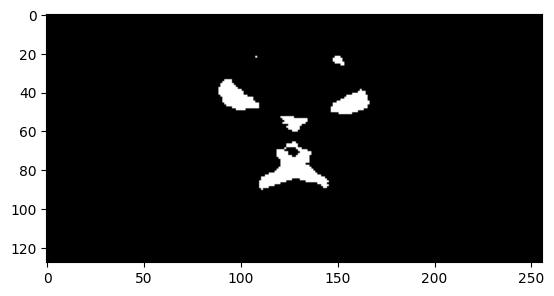

IBSR_07


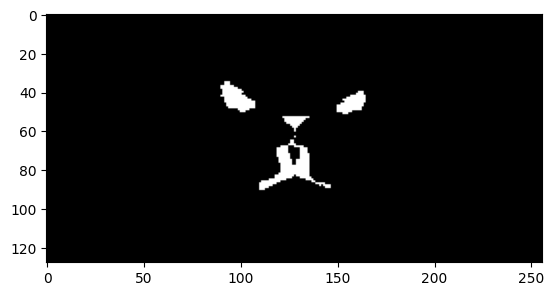

IBSR_08


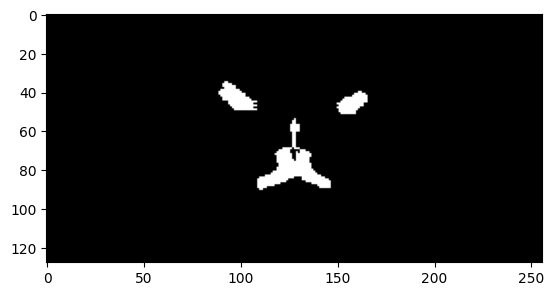

IBSR_09


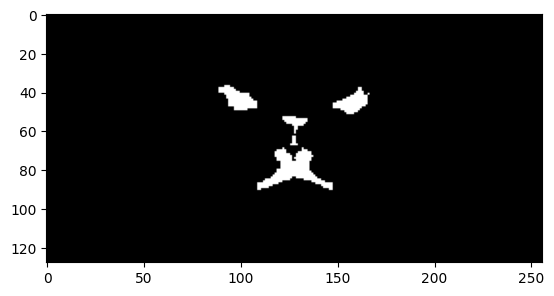

IBSR_16


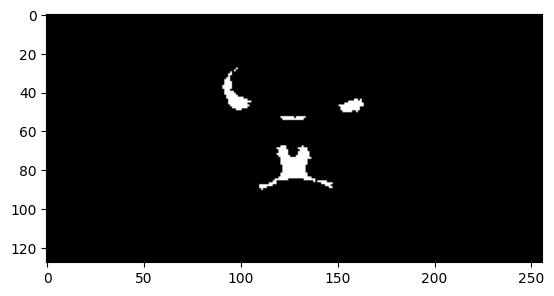

IBSR_18


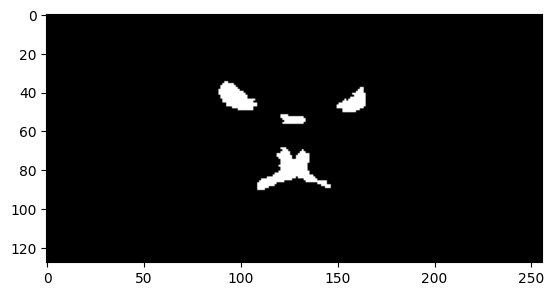

In [132]:
for i in range(len(seg_list)):
    print(df_try['Moving Image'].iloc[i])
    # plot first segmentation file
    plt.imshow(sitk.GetArrayViewFromImage(seg_list[i])[140,:,:] ==1, cmap="gray")
    plt.show()


In [133]:
get_img_info(seg_list[0])

for i in range(len(seg_list)):
    get_img_info(seg_list[i])

Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370540142059326, 1.5, 0.8370540142059326) 
	Origin: (213.44900512695312, 0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 32-bit float
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370540142059326, 1.5, 0.8370540142059326) 
	Origin: (213.44900512695312, 0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 32-bit float
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370540142059326, 1.5, 0.8370540142059326) 
	Origin: (213.44900512695312, 0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 32-bit float
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370540142059326, 1.5, 0.8370540142059326) 
	Origin: (213.44900512695312, 0.0, 0.0) 
	Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) 
	Pixel type: 32-bit float
Image info: 
	Size: (256, 128, 256) 
	Spacing: (0.8370540142059326, 1.5, 0.8370540142059326) 
	Origin: (213.4490

In [134]:
# generate a list of arrays
seg_array_list = [sitk.GetArrayFromImage(seg) for seg in seg_list]

In [135]:
# get the probability atlas with weights for each CSF, GM, and WM label
def get_prob_atlas(seg_array_list, weight_list=None):
    if weight_list is None:
        weight_list = [1] * len(seg_array_list)

    prob_atlas_csf = np.zeros_like(seg_array_list[0])
    prob_atlas_gm = np.zeros_like(seg_array_list[0])
    prob_atlas_wm = np.zeros_like(seg_array_list[0])
    
    for i, seg_array in enumerate(seg_array_list):
        prob_atlas_csf += (seg_array == 1) * weight_list[i]
        prob_atlas_gm += (seg_array == 2) * weight_list[i]
        prob_atlas_wm += (seg_array == 3) * weight_list[i]
    
    prob_atlas_csf /= np.sum(weight_list)
    prob_atlas_gm /= np.sum(weight_list)
    prob_atlas_wm /= np.sum(weight_list)
    
    # put in a dictionary
    prob_atlas = {}
    prob_atlas["csf"] = prob_atlas_csf
    prob_atlas["gm"] = prob_atlas_gm
    prob_atlas["wm"] = prob_atlas_wm
    
    return prob_atlas

In [153]:
weights = df_try["MSE"].values
weights = weights / np.sum(weights)
weights

array([0.08516179, 0.10093192, 0.10588155, 0.11397439, 0.10825812,
       0.12804145, 0.13288065, 0.13138121, 0.0453795 , 0.04810943])

In [154]:
# generate a probability atlas with weights
prob_atlas_weighted = get_prob_atlas(seg_array_list, weights)

In [138]:
prob_atlas = get_prob_atlas(seg_array_list)

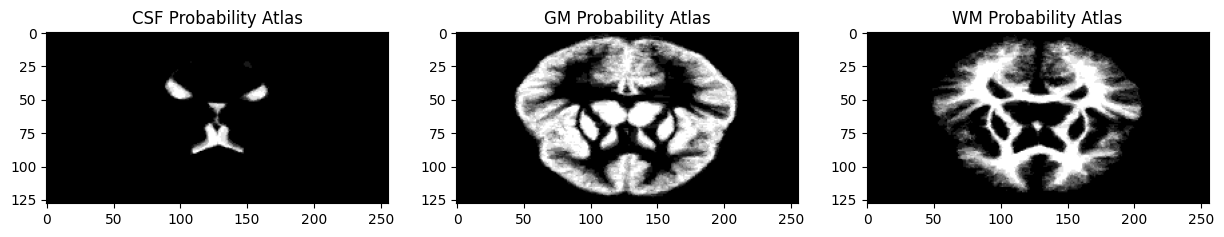

In [147]:
# plot the probability atlas
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(prob_atlas["csf"][140,:,:], cmap="gray")
plt.title("CSF Probability Atlas")
plt.subplot(1,3,2)
plt.imshow(prob_atlas["gm"][140,:,:], cmap="gray")
plt.title("GM Probability Atlas")
plt.subplot(1,3,3)
plt.imshow(prob_atlas["wm"][140,:,:], cmap="gray")
plt.title("WM Probability Atlas")
plt.show()

In [148]:
def process_image_atlas(atlas_labels, slice_n = 160, plot=False):
    orig_shape = atlas_labels['csf'].shape
    
    tissue_mask = (atlas_labels['csf'] + atlas_labels['gm'] + atlas_labels['wm']) != 0

    prob_csf_test = atlas_labels['csf'][tissue_mask == 1].reshape(-1, 1)
    prob_wm_test = atlas_labels['wm'][tissue_mask == 1].reshape(-1, 1)
    prob_gm_test = atlas_labels['gm'][tissue_mask == 1].reshape(-1, 1)

    prob_atlas = np.concatenate((prob_csf_test, prob_gm_test, prob_wm_test), axis=1)

    atlas_argmax_res = np.argmax(prob_atlas, axis=1)

    labels_atlas = np.zeros(orig_shape)
    labels_atlas[tissue_mask == 1] = atlas_argmax_res + 1

    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(8, 8))

        axs = axs.flatten()

        axs[0].imshow(labels_atlas[slice_n, :, :], cmap='jet')
        axs[0].set_title('Labeled image')

        axs[1].imshow(labels_atlas[slice_n, :, :] == 1, cmap='gray')
        axs[1].set_title('csf')

        axs[2].imshow(labels_atlas[slice_n, :, :] == 2, cmap='gray')
        axs[2].set_title('gm')

        axs[3].imshow(labels_atlas[slice_n, :, :] == 3, cmap='gray')
        axs[3].set_title('wm')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

    return labels_atlas

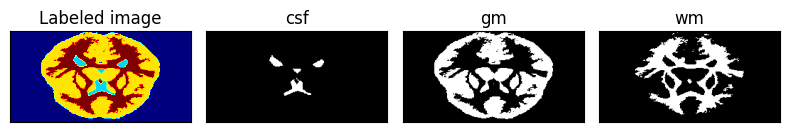

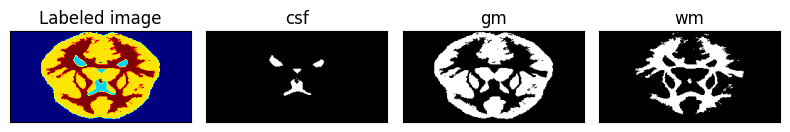

In [155]:
# segment the atlas
labels_atlas_weighted = process_image_atlas(prob_atlas_weighted, slice_n=139, plot=True)

labels_atlas = process_image_atlas(prob_atlas, slice_n=139, plot=True)

In [150]:
def calculate_dice_score(labels_seg, labels_gt, print_score=True):
    dice_score = {}
    
    # please check what are the actual label values for the dataset you are working with

    label_seg_csf = labels_seg == 1
    label_seg_gm = labels_seg == 2
    label_seg_wm = labels_seg == 3

    label_gt_csf = labels_gt == 1
    label_gt_gm = labels_gt == 2
    label_gt_wm = labels_gt == 3

    dice_score['csf'] = np.sum(label_gt_csf[label_seg_csf]) * 2.0 / (np.sum(label_gt_csf) + np.sum(label_seg_csf))
    dice_score['gm'] = np.sum(label_gt_gm[label_seg_gm]) * 2.0 / (np.sum(label_gt_gm) + np.sum(label_seg_gm))
    dice_score['wm'] = np.sum(label_gt_wm[label_seg_wm]) * 2.0 / (np.sum(label_gt_wm) + np.sum(label_seg_wm))

    if print_score:
        print('Dice scores:')
        for key, value in dice_score.items():
            print(f'{key}: {value}')
            
        print(f'Average: {np.mean(list(dice_score.values()))}')

    return dice_score

In [143]:
df_try["Validation Label"].iloc[0]

'D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project\\dataset\\Validation_Set\\IBSR_17\\IBSR_17_seg.nii.gz'

In [156]:

# load the ground truth segmentation
gt = sitk.ReadImage(df_try["Validation Label"].iloc[0])

# get the array
gt_array = sitk.GetArrayFromImage(gt)

# calculate the dice score
dice_score = calculate_dice_score(labels_atlas, gt_array)

# calculate the dice score
dice_score_weighted = calculate_dice_score(labels_atlas_weighted, gt_array)

Dice scores:
csf: 0.8692663796066065
gm: 0.8441251624988414
wm: 0.7781657345595848
Dice scores:
csf: 0.8663077521442755
gm: 0.8335524600728139
wm: 0.7731287648663955


In [475]:
# perform segmentation on the test images using weighted voting of the atlases (registered segmentation labels) from the df dataframe
# weight type can be "MI", "MSE", "PSNR" or "SSIM"

def weighted_voting(df, val_or_test, weight_type, output_dir, verbose=False):
    """
    Perform weighted voting of atlases (registered segmentation labels) to segment

    Parameters
    ----------
    df (pandas dataframe): Dataframe with the results of the metrics.
    val_or_test (str): "val" or "test".
    weight_type (str): Type of weight to use. Can be "MI", "MSE", "PSNR" or "SSIM".
    output_dir (str): Output directory.
    verbose (bool): Optional verbose output.
    """
    
    if val_or_test == "val":
        df = df.loc[df['Fixed Type'] == "val"]
    elif val_or_test == "test":
        df = df.loc[df['Fixed Type'] == "test"]
        
    if weight_type == "MI":
        df = df.sort_values(by=['MI'], ascending=False)
    elif weight_type == "MSE":
        df = df.sort_values(by=['MSE'], ascending=True)
    elif weight_type == "PSNR":
        df = df.sort_values(by=['PSNR'], ascending=False)
    elif weight_type == "SSIM":
        df = df.sort_values(by=['SSIM'], ascending=False)
        
    # get the filenames of the images to segment
    fixed_images_list = df['Fixed Image'].unique()
    
    # loop over the images
    for i in range(len(fixed_images_list)):
        print(f"Segmenting {fixed_images_list[i]} ({i+1}/{len(fixed_images_list)})")
        
        # get path to the atlas labels
        atlas_labels_path_list = df.loc[df['Fixed Image'] == fixed_images_list[i], 'Registered Label'].iloc[0]
        
        # get the path to the image to segment
        fixed_image_path = all_filenames[fixed_images_list[i]]
        
        # read image
        fixed_img = sitk.ReadImage(fixed_image_path, sitk.sitkInt16)
        # convert to numpy array
        fixed_img_array = sitk.GetArrayFromImage(fixed_img)
        
        for j in range(len(atlas_labels_path_list)):
            # read atlas label
            atlas_label = sitk.ReadImage(atlas_labels_path_list[j], sitk.sitkInt16)
            # convert to numpy array
            atlas_label_array = sitk.GetArrayFromImage(atlas_label)
            
            
        

# perform weighted voting using MI
weighted_voting(
    df=df,
    val_or_test="val",
    weight_type="MI",
    output_dir=os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "weighted_voting"),
    verbose=False,
)
        


Segmenting IBSR_11 (1/5)


IndexError: single positional indexer is out-of-bounds